# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

### Откройте файл с данными и изучите общую информацию. 

In [1]:
import pandas as pd
data=pd.read_csv('/datasets/real_estate_data.csv', sep="\t")

In [2]:
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

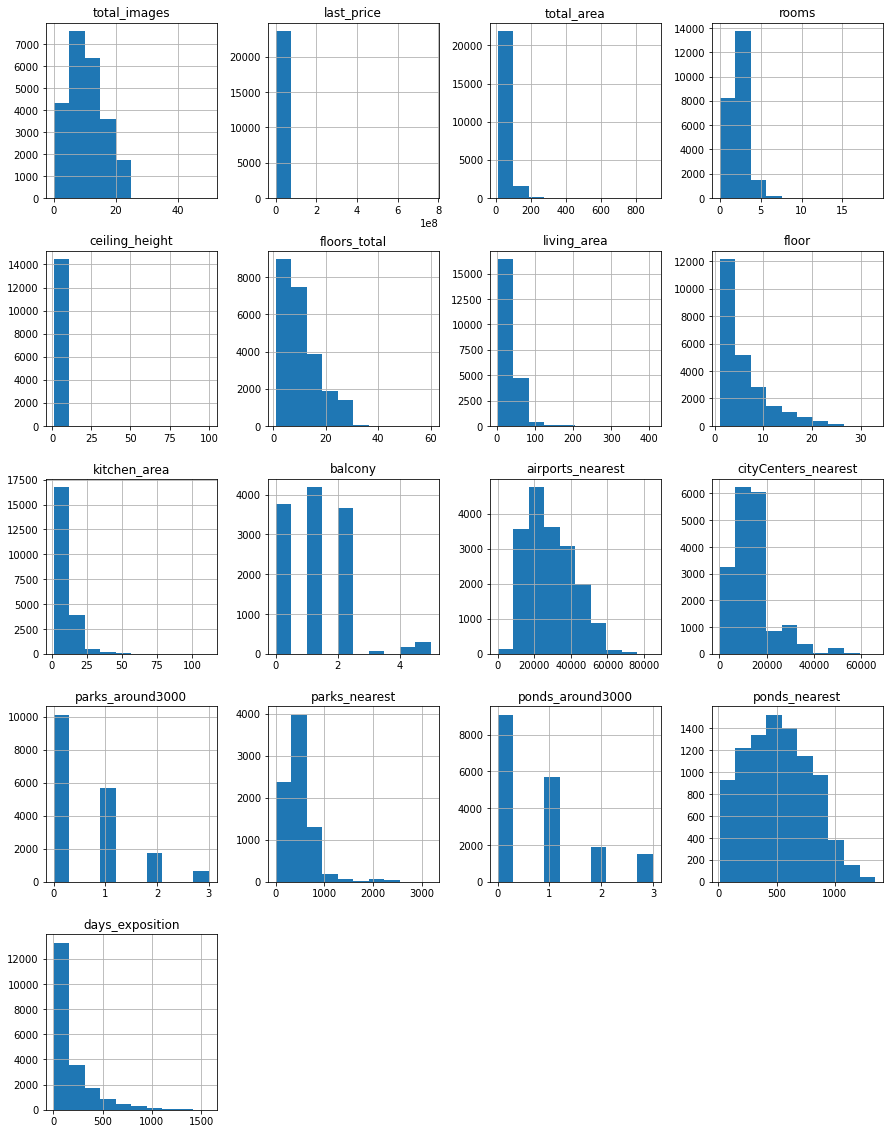

In [4]:
data.hist(figsize=(15, 20));

Из подозрительных данных видно это высота потолка, и на мой взгляд подозрительно колличество балконов больше 4. Это проверим.

### Предобработка данных

In [5]:
data.isna().sum() #Определим пропуски в данных

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

In [6]:
print(data['ponds_nearest'].unique())

[ 755.   nan  574. ...  959.   40. 1134.]


In [7]:
data[data['ponds_around3000']==0]['ponds_around3000'].count()#Чему равны значения расстояния до ближайшего пруда 

9071

In [8]:
data[data['ponds_around3000'].isna()]['ponds_around3000']

5       NaN
8       NaN
12      NaN
22      NaN
30      NaN
         ..
23683   NaN
23692   NaN
23695   NaN
23696   NaN
23698   NaN
Name: ponds_around3000, Length: 5518, dtype: float64

In [9]:
5518+9071

14589

In [10]:
data['is_apartment']=data['is_apartment'].fillna(False) #Заменим пропуски в is_apartment на False, так как вероятнее
#всего эти пропуски значат то, что объект не расчитан под жилье
#data[data['is_apartment']==True]

Неизвестное колличесво этажей в здании заполним номером этажа самого помещения, думаю это самое логичное.


In [11]:
data['floors_total']=data['floors_total'].fillna(data['floor'])

Пропуски в balcony заполним нулями, будем считать что в помещении нет балкона.


In [12]:
data['balcony']=data['balcony'].fillna(0)

Отредактировано

>Столбец с днями размещения объявления имеет пропуски. Думаю что заполнив нулями, мы просто получим выборку  с нулевыми днями, которую потом все равно придется отсеять. Так как тут 3181 строка, попробую заполнить нулями, а дальше посмотрю как это мне аукнется, в крайнем случае удалю потом

Думаю нужно избавить от неявных дубликатов в названии локации.

In [14]:
data.duplicated().sum()

0

Типовых дубликатов в ДФ нет. Изменим названия локаций: изменим все ё на е, так же приравняем все поселки к ПГТ:

In [15]:
data['locality_name'].value_counts()

Санкт-Петербург                       15721
посёлок Мурино                          522
посёлок Шушары                          440
Всеволожск                              398
Пушкин                                  369
                                      ...  
деревня Малая Романовка                   1
коттеджный поселок Кивеннапа Север        1
поселок Коробицыно                        1
городской посёлок Свирьстрой              1
поселок Коммунары                         1
Name: locality_name, Length: 364, dtype: int64

In [16]:
data['locality_name'].unique() #уникальные значения всех населенных пунктов

array(['Санкт-Петербург', 'посёлок Шушары', 'городской посёлок Янино-1',
       'посёлок Парголово', 'посёлок Мурино', 'Ломоносов', 'Сертолово',
       'Петергоф', 'Пушкин', 'деревня Кудрово', 'Коммунар', 'Колпино',
       'поселок городского типа Красный Бор', 'Гатчина', 'поселок Мурино',
       'деревня Фёдоровское', 'Выборг', 'Кронштадт', 'Кировск',
       'деревня Новое Девяткино', 'посёлок Металлострой',
       'посёлок городского типа Лебяжье',
       'посёлок городского типа Сиверский', 'поселок Молодцово',
       'поселок городского типа Кузьмоловский',
       'садовое товарищество Новая Ропша', 'Павловск',
       'деревня Пикколово', 'Всеволожск', 'Волхов', 'Кингисепп',
       'Приозерск', 'Сестрорецк', 'деревня Куттузи', 'посёлок Аннино',
       'поселок городского типа Ефимовский', 'посёлок Плодовое',
       'деревня Заклинье', 'поселок Торковичи', 'поселок Первомайское',
       'Красное Село', 'посёлок Понтонный', 'Сясьстрой', 'деревня Старая',
       'деревня Лесколово', '

In [17]:
data['locality_name']=data['locality_name'].astype('str')#приведем все названия к строкм. У меня возникала ошибка, что
                                                         #некоторые строки названий имеют формат float
for i in range(len(data['locality_name'])):
    if "ё" in data.loc[i,'locality_name']:
        data.loc[i,'locality_name']=data.loc[i,'locality_name'].replace('ё','е')
    if "городской поселок" in data.loc[i,'locality_name']:
        data.loc[i,'locality_name']=data.loc[i,'locality_name'].replace('городской поселок','поселок городского типа')
    if "поселок городского типа" not in data.loc[i,'locality_name'] and "поселок" in data.loc[i,'locality_name']:
        data.loc[i,'locality_name']=data.loc[i,'locality_name'].replace('поселок','поселок городского типа')
    if "nan" in data.loc[i,'locality_name']:
        data.loc[i,'locality_name']=data.loc[i,'locality_name'].replace('nan','Безимянный')   
    data.loc[i,'locality_name']=data.loc[i,'locality_name'].replace('поселок городского типа','ПГТ')
        

data['locality_name'].value_counts()

Санкт-Петербург          15721
ПГТ Мурино                 556
ПГТ Шушары                 440
Всеволожск                 398
Пушкин                     369
                         ...  
деревня Кисельня             1
деревня Котлы                1
деревня Трубников Бор        1
деревня Нижняя               1
ПГТ Гладкое                  1
Name: locality_name, Length: 323, dtype: int64

In [18]:
data['locality_name'].unique()

array(['Санкт-Петербург', 'ПГТ Шушары', 'ПГТ Янино-1', 'ПГТ Парголово',
       'ПГТ Мурино', 'Ломоносов', 'Сертолово', 'Петергоф', 'Пушкин',
       'деревня Кудрово', 'Коммунар', 'Колпино', 'ПГТ Красный Бор',
       'Гатчина', 'деревня Федоровское', 'Выборг', 'Кронштадт', 'Кировск',
       'деревня Новое Девяткино', 'ПГТ Металлострой', 'ПГТ Лебяжье',
       'ПГТ Сиверский', 'ПГТ Молодцово', 'ПГТ Кузьмоловский',
       'садовое товарищество Новая Ропша', 'Павловск',
       'деревня Пикколово', 'Всеволожск', 'Волхов', 'Кингисепп',
       'Приозерск', 'Сестрорецк', 'деревня Куттузи', 'ПГТ Аннино',
       'ПГТ Ефимовский', 'ПГТ Плодовое', 'деревня Заклинье',
       'ПГТ Торковичи', 'ПГТ Первомайское', 'Красное Село',
       'ПГТ Понтонный', 'Сясьстрой', 'деревня Старая',
       'деревня Лесколово', 'ПГТ Новый Свет', 'Сланцы', 'село Путилово',
       'Ивангород', 'Мурино', 'Шлиссельбург', 'Никольское', 'Зеленогорск',
       'Сосновый Бор', 'деревня Оржицы', 'деревня Кальтино', 'Кудрово',
  

In [19]:
data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total                0
living_area              1903
floor                       0
is_apartment                0
studio                      0
open_plan                   0
kitchen_area             2278
balcony                     0
locality_name               0
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

Создам функцию, которая выдает медианное значение необходимого параметра по названию локации

In [20]:
med_data=data.pivot_table(index='locality_name',aggfunc='median') 
def median_type_paste(name,category):
    x=med_data.loc[name,category]
    return x
median_type_paste('Санкт-Петербург','airports_nearest')


26757.5

Заменим ['ceiling_height'] на медианные значения по поселению.

Было:['ceiling_height','airports_nearest','cityCenters_nearest','ponds_around3000','parks_around3000']

In [21]:
for i in ['ceiling_height']:
    for n in data['locality_name'].unique():
        data[i]=data[i].fillna(median_type_paste(n,i))
data.isna().sum()  

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height              0
floors_total                0
living_area              1903
floor                       0
is_apartment                0
studio                      0
open_plan                   0
kitchen_area             2278
balcony                     0
locality_name               0
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

Пропуски, где есть пруды в радиусе 3км, заполним медианным значениями для населенного пункта.

Остаются пропуски в жилой площади и кухни. Вероятно, заполнить это пропуски тяжелее всего. Если просто заполнить нулями, то эти нули могут в дальнейшем сыграть плохую роль при определенных математических операциях. Однако если заполнить "пустотой"-"", то есть вероятность что при опредленных группировках вылезут значения NaN, и в итогу мы так и выбросим эти данные....

Пропуски я убрал. 
Займемся аномалиями.


In [26]:
data.describe()

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
count,23699.000000,2.369900e+04,23699.000000,23699.000000,23699.000000,23699.000000,21796.000000,23699.000000,21421.000000,23699.000000,18157.000000,18180.000000,18181.000000,8079.000000,18181.000000,9110.000000,20518.000000
mean,9.858475,6.541549e+06,60.348651,2.070636,2.743758,10.671463,34.457852,5.892358,10.569807,0.591080,28793.672193,14191.277833,0.611408,490.804555,0.770255,517.980900,180.888634
std,5.682529,1.088701e+07,35.654083,1.078405,0.987138,6.595802,22.030445,4.885249,5.905438,0.959298,12630.880622,8608.386210,0.802074,342.317995,0.938346,277.720643,219.727988
min,0.000000,1.219000e+04,12.000000,0.000000,1.000000,1.000000,2.000000,1.000000,1.300000,0.000000,0.000000,181.000000,0.000000,1.000000,0.000000,13.000000,1.000000
25%,6.000000,3.400000e+06,40.000000,1.000000,2.600000,5.000000,18.600000,2.000000,7.000000,0.000000,18585.000000,9238.000000,0.000000,288.000000,0.000000,294.000000,45.000000
50%,9.000000,4.650000e+06,52.000000,2.000000,2.700000,9.000000,30.000000,4.000000,9.100000,0.000000,26726.000000,13098.500000,0.000000,455.000000,1.000000,502.000000,95.000000
75%,14.000000,6.800000e+06,69.900000,3.000000,2.700000,16.000000,42.300000,8.000000,12.000000,1.000000,37273.000000,16293.000000,1.000000,612.000000,1.000000,729.000000,232.000000
max,50.000000,7.630000e+08,900.000000,19.000000,100.000000,60.000000,409.700000,33.000000,112.000000,5.000000,84869.000000,65968.000000,3.000000,3190.000000,3.000000,1344.000000,1580.000000


СТранные значения: 0 комнат. Площадь 900кв м. 

In [27]:
data[data['total_area']>500]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
3117,19,140000000.0,631.0,2019-03-30T00:00:00,7,2.70,5.0,NaN,5,False,...,60.0,0.0,Санкт-Петербург,25707.0,4972.0,0.0,NaN,2.0,210.0,NaN
4237,1,50000000.0,517.0,2017-10-14T00:00:00,7,2.70,4.0,332.0,3,False,...,22.0,0.0,Санкт-Петербург,22835.0,1847.0,2.0,477.0,2.0,540.0,NaN
5358,20,65000000.0,590.0,2019-02-14T00:00:00,15,3.50,6.0,409.0,3,False,...,100.0,0.0,Санкт-Петербург,24447.0,4666.0,1.0,767.0,0.0,NaN,14.0
8018,20,84000000.0,507.0,2015-12-17T00:00:00,5,4.45,7.0,301.5,7,True,...,45.5,1.0,Санкт-Петербург,NaN,5735.0,2.0,110.0,0.0,NaN,1078.0
12859,20,140000000.0,631.2,2019-04-09T00:00:00,7,3.90,4.0,322.3,4,False,...,19.5,1.0,Санкт-Петербург,25707.0,4972.0,0.0,NaN,2.0,210.0,NaN
15651,20,300000000.0,618.0,2017-12-18T00:00:00,7,3.40,7.0,258.0,5,False,...,70.0,0.0,Санкт-Петербург,32440.0,5297.0,0.0,NaN,2.0,198.0,111.0
19540,8,420000000.0,900.0,2017-12-06T00:00:00,12,2.80,25.0,409.7,25,False,...,112.0,0.0,Санкт-Петербург,30706.0,7877.0,0.0,NaN,2.0,318.0,106.0


Рассмотрим высоту потолков

In [28]:
data.sort_values(by='ceiling_height',ascending=False).head(10)


,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
22869,0,15000000.0,25.0,2018-07-25T00:00:00,1,100.0,5.0,14.0,5,True,...,11.0,5.0,Санкт-Петербург,34963.0,8283.0,1.0,223.0,3.0,30.0,19.0
22336,19,9999000.0,92.4,2019-04-05T00:00:00,2,32.0,6.0,55.5,5,False,...,16.5,4.0,Санкт-Петербург,18838.0,3506.0,0.0,NaN,3.0,511.0,NaN
3148,14,2900000.0,75.0,2018-11-12T00:00:00,3,32.0,3.0,53.0,2,False,...,8.0,0.0,Волхов,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21377,19,4900000.0,42.0,2017-04-18T00:00:00,1,27.5,24.0,37.7,19,False,...,11.0,2.0,Санкт-Петербург,42742.0,9760.0,0.0,NaN,0.0,NaN,61.0
4876,7,3000000.0,25.0,2017-09-27T00:00:00,0,27.0,25.0,17.0,17,False,...,NaN,2.0,ПГТ Мурино,NaN,NaN,NaN,NaN,NaN,NaN,28.0
5807,17,8150000.0,80.0,2019-01-09T00:00:00,2,27.0,36.0,41.0,13,False,...,12.0,5.0,Санкт-Петербург,18732.0,20444.0,0.0,NaN,3.0,80.0,38.0
20478,11,8000000.0,45.0,2017-07-18T00:00:00,1,27.0,4.0,22.0,2,False,...,10.0,1.0,Санкт-Петербург,18975.0,3246.0,0.0,NaN,3.0,449.0,429.0
10773,8,3800000.0,58.0,2017-10-13T00:00:00,2,27.0,10.0,30.1,3,False,...,8.1,2.0,ПГТ Мурино,NaN,NaN,NaN,NaN,NaN,NaN,71.0
5246,0,2500000.0,54.0,2017-10-13T00:00:00,2,27.0,5.0,30.0,3,False,...,9.0,2.0,деревня Мины,NaN,NaN,NaN,NaN,NaN,NaN,540.0
22938,14,4000000.0,98.0,2018-03-15T00:00:00,4,27.0,2.0,73.0,2,True,...,9.0,1.0,деревня Нижняя,NaN,NaN,NaN,NaN,NaN,NaN,27.0


[[<AxesSubplot:title={'center':'ceiling_height'}>]] [[<AxesSubplot:title={'center':'ceiling_height'}>]] [[<AxesSubplot:title={'center':'ceiling_height'}>]]


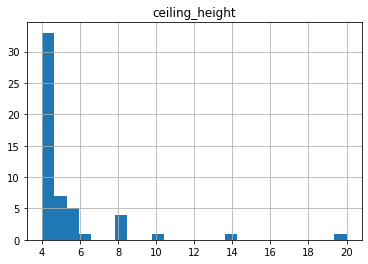

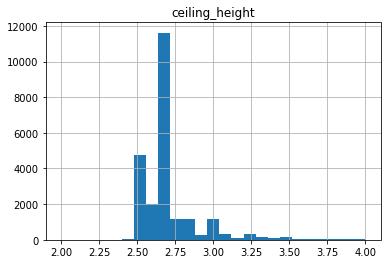

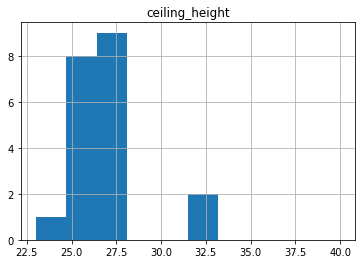

In [29]:
import matplotlib.pyplot as plt
print(data[data['ceiling_height']>4].hist('ceiling_height',bins=25,range=(4,20))
      ,data[data['ceiling_height']>2].hist('ceiling_height',bins=25,range=(2,4))
      ,data[data['ceiling_height']>20].hist('ceiling_height',bins=10,range=(23,40)))

Минимальной нормой для потолков считается 2.4 метра. В распределении есть значения выше 10. Вероятно все значения выше 24 можно делать на 10, ссылаясь на то, что это ошибка внесения данных. Но надо проверить что за значения находящиеся в диапазоне от 10 до 24, так как есть поделить 12 на 10, получится потолок маловатый даже для хоббитов.

In [30]:

data.sort_values(by='ceiling_height',ascending=False)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
22869,0,15000000.0,25.0,2018-07-25T00:00:00,1,100.00,5.0,14.0,5,True,...,11.00,5.0,Санкт-Петербург,34963.0,8283.0,1.0,223.0,3.0,30.0,19.0
22336,19,9999000.0,92.4,2019-04-05T00:00:00,2,32.00,6.0,55.5,5,False,...,16.50,4.0,Санкт-Петербург,18838.0,3506.0,0.0,NaN,3.0,511.0,NaN
3148,14,2900000.0,75.0,2018-11-12T00:00:00,3,32.00,3.0,53.0,2,False,...,8.00,0.0,Волхов,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21377,19,4900000.0,42.0,2017-04-18T00:00:00,1,27.50,24.0,37.7,19,False,...,11.00,2.0,Санкт-Петербург,42742.0,9760.0,0.0,NaN,0.0,NaN,61.0
4876,7,3000000.0,25.0,2017-09-27T00:00:00,0,27.00,25.0,17.0,17,False,...,NaN,2.0,ПГТ Мурино,NaN,NaN,NaN,NaN,NaN,NaN,28.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2572,4,2400000.0,62.0,2018-12-27T00:00:00,3,2.00,5.0,40.0,4,False,...,6.00,1.0,Луга,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20520,9,3600000.0,38.0,2018-07-05T00:00:00,1,2.00,12.0,15.0,9,False,...,11.80,1.0,Кудрово,NaN,NaN,NaN,NaN,NaN,NaN,62.0
16934,5,4100000.0,40.0,2017-10-17T00:00:00,1,1.75,37.0,17.4,5,False,...,8.34,0.0,Санкт-Петербург,18732.0,20444.0,0.0,NaN,3.0,80.0,71.0
5712,5,1500000.0,42.8,2017-08-14T00:00:00,2,1.20,2.0,27.5,1,False,...,5.20,0.0,ПГТ Мга,NaN,NaN,NaN,NaN,NaN,NaN,248.0


Для меня подозрительно, что в 14-этажке может быть потолок 14 метров, как и 8 метров в 16-этажке. Считаю логичным просто удалить эти данные. В реальном проекте возможно стоило бы уточнить это по фото приложенным к объявлению, но в общем-то, таких строк очень мало. По распределению выше видно, что большая часть это потолки от 2.4 до 4.2 А затем ошибочные данные от 24 до 40. Вижу верным исправить последние и удалить значения от 4.2 до 24. Всего 36 строк - не страшно.

Сначала переведем ошибочные значения >24 до нормальных делением на 10

[[<AxesSubplot:title={'center':'ceiling_height'}>]] [[<AxesSubplot:title={'center':'ceiling_height'}>]] [[<AxesSubplot:title={'center':'ceiling_height'}>]]


,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
20507,12,5950000.0,60.00,2018-02-19T00:00:00,2,22.60,14.0,35.0,11,False,...,13.00,1.0,Санкт-Петербург,27028.0,12570.0,0.0,NaN,0.0,NaN,40.0
17496,15,6700000.0,92.90,2019-02-19T00:00:00,3,20.00,17.0,53.2,14,False,...,12.00,5.0,Санкт-Петербург,16295.0,15092.0,1.0,967.0,0.0,NaN,NaN
15061,19,5600000.0,56.40,2018-05-11T00:00:00,2,14.00,14.0,32.4,5,False,...,9.10,2.0,Санкт-Петербург,14814.0,13610.0,0.0,NaN,0.0,NaN,315.0
22309,20,5300000.0,45.00,2017-09-30T00:00:00,1,10.30,16.0,15.5,15,False,...,NaN,0.0,Санкт-Петербург,36353.0,11936.0,2.0,440.0,2.0,450.0,136.0
22869,0,15000000.0,25.00,2018-07-25T00:00:00,1,10.00,5.0,14.0,5,True,...,11.00,5.0,Санкт-Петербург,34963.0,8283.0,1.0,223.0,3.0,30.0,19.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4212,1,2120000.0,35.43,2017-12-18T00:00:00,1,2.00,18.0,16.6,9,False,...,8.80,2.0,Тосно,NaN,NaN,NaN,NaN,NaN,NaN,36.0
16884,0,1500000.0,33.00,2018-10-03T00:00:00,1,2.00,5.0,20.0,5,False,...,6.00,0.0,Выборг,NaN,NaN,NaN,NaN,NaN,NaN,6.0
16934,5,4100000.0,40.00,2017-10-17T00:00:00,1,1.75,37.0,17.4,5,False,...,8.34,0.0,Санкт-Петербург,18732.0,20444.0,0.0,NaN,3.0,80.0,71.0
5712,5,1500000.0,42.80,2017-08-14T00:00:00,2,1.20,2.0,27.5,1,False,...,5.20,0.0,ПГТ Мга,NaN,NaN,NaN,NaN,NaN,NaN,248.0


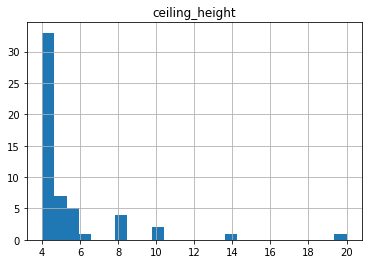

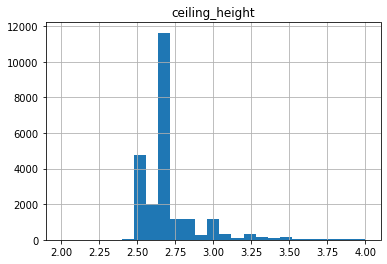

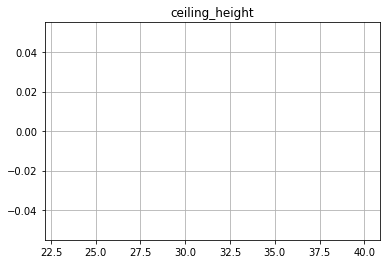

In [31]:

for i in range(len(data['ceiling_height'])):
    if data.loc[i,'ceiling_height'] >=24.0:
        data.loc[i,'ceiling_height']=(data.loc[i,'ceiling_height'])/10


        
print(data[data['ceiling_height']>4.0].hist('ceiling_height',bins=25,range=(4,20))
      ,data[data['ceiling_height']>2.0].hist('ceiling_height',bins=25,range=(2,4))
      ,data[data['ceiling_height']>20].hist('ceiling_height',bins=10,range=(23,40)))
data.sort_values(by='ceiling_height',ascending=False)

In [32]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        23699 non-null  float64
 6   floors_total          23699 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          23699 non-null  bool   
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               23699 non-null  float64
 14  locality_name         23699 non-null  object 
 15  airports_nearest   

In [33]:

data=data[(data['ceiling_height']>=2.4) & (data['ceiling_height']<=4.2)]

data.sort_values(by='ceiling_height',ascending=False)


,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
6617,17,3100000.0,35.2,2018-08-23T00:00:00,1,4.2,6.0,17.0,6,False,...,10.0,1.0,Всеволожск,NaN,NaN,NaN,NaN,NaN,NaN,15.0
7279,4,18000000.0,127.0,2016-05-17T00:00:00,3,4.2,3.0,83.8,1,False,...,11.4,0.0,Санкт-Петербург,24899.0,4785.0,0.0,NaN,1.0,603.0,970.0
22055,2,8550000.0,75.1,2017-08-09T00:00:00,3,4.2,6.0,52.5,3,False,...,8.0,0.0,Санкт-Петербург,23060.0,2602.0,1.0,584.0,0.0,NaN,477.0
22494,7,91075000.0,491.0,2017-05-27T00:00:00,5,4.2,9.0,274.0,9,False,...,45.0,0.0,Санкт-Петербург,25525.0,5845.0,2.0,116.0,0.0,NaN,115.0
11128,12,10300000.0,80.5,2018-02-01T00:00:00,3,4.2,5.0,37.0,5,False,...,34.0,1.0,Пушкин,19907.0,32061.0,0.0,NaN,0.0,NaN,105.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7270,2,2400000.0,51.7,2017-09-12T00:00:00,2,2.4,6.0,29.7,3,False,...,8.2,1.0,деревня Малое Верево,NaN,NaN,NaN,NaN,NaN,NaN,42.0
21401,17,4600000.0,39.0,2019-04-28T00:00:00,2,2.4,9.0,23.8,8,False,...,7.4,0.0,Санкт-Петербург,12384.0,12296.0,0.0,NaN,1.0,396.0,NaN
14345,16,6400000.0,56.0,2017-11-27T00:00:00,2,2.4,12.0,36.0,11,False,...,17.0,2.0,Санкт-Петербург,26766.0,10939.0,1.0,524.0,1.0,913.0,120.0
5076,0,3850000.0,30.5,2018-10-03T00:00:00,1,2.4,5.0,19.5,1,True,...,5.5,0.0,Санкт-Петербург,29686.0,8389.0,3.0,397.0,1.0,578.0,7.0


In [34]:
data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height              0
floors_total                0
living_area              1896
floor                       0
is_apartment                0
studio                      0
open_plan                   0
kitchen_area             2268
balcony                     0
locality_name               0
airports_nearest         5520
cityCenters_nearest      5500
parks_around3000         5499
parks_nearest           15587
ponds_around3000         5499
ponds_nearest           14558
days_exposition          3171
dtype: int64

Пропуски и аномальные значения исключены. 

Займемся изменением типов данных в ДФ.

In [35]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23641 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23641 non-null  int64  
 1   last_price            23641 non-null  float64
 2   total_area            23641 non-null  float64
 3   first_day_exposition  23641 non-null  object 
 4   rooms                 23641 non-null  int64  
 5   ceiling_height        23641 non-null  float64
 6   floors_total          23641 non-null  float64
 7   living_area           21745 non-null  float64
 8   floor                 23641 non-null  int64  
 9   is_apartment          23641 non-null  bool   
 10  studio                23641 non-null  bool   
 11  open_plan             23641 non-null  bool   
 12  kitchen_area          21373 non-null  float64
 13  balcony               23641 non-null  float64
 14  locality_name         23641 non-null  object 
 15  airports_nearest   

Количество этажей,дней с выставки объявления, балконов,парков и прудов в радиусе 3км стоит перевести в int. Название населенного пункта в строки.

In [36]:
#data['ponds_around3000']=data['ponds_around3000'].astype('int')
#data['parks_around3000']=data['parks_around3000'].astype('int')
data['floors_total']=data['floors_total'].astype('int')
#data['days_exposition']=data['days_exposition'].astype('int')
data['balcony']=data['balcony'].astype('int')
data['locality_name']=data['locality_name'].astype('string')

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23641 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23641 non-null  int64  
 1   last_price            23641 non-null  float64
 2   total_area            23641 non-null  float64
 3   first_day_exposition  23641 non-null  object 
 4   rooms                 23641 non-null  int64  
 5   ceiling_height        23641 non-null  float64
 6   floors_total          23641 non-null  int64  
 7   living_area           21745 non-null  float64
 8   floor                 23641 non-null  int64  
 9   is_apartment          23641 non-null  bool   
 10  studio                23641 non-null  bool   
 11  open_plan             23641 non-null  bool   
 12  kitchen_area          21373 non-null  float64
 13  balcony               23641 non-null  int64  
 14  locality_name         23641 non-null  string 
 15  airports_nearest   

Промежуточный вывод:

Была выполнена предобработка данных сервиса Яндекс Недвижимость — архива объявлений за несколько лет о продаже квартир в Санкт-Петербурге и соседних населённых пунктах. В процессе данной части проекта были выполнены следующие пункты:

-Найдены и заменыны пропуски в данных;
Пропуски в balcony заполним нулями, будем считать что в помещении нет балкона.

-В столбце с названием населенных пунктов были скорректированы наименования, приведены к единому типу для того, чтобы избежать неявных дубликтаов;

-Исправлены аномальные значения в столбце с балконами;

-Изменены типы данных столбцов, с пояснением по какой причине это было выполнено.



In [37]:
data.columns

Index(['total_images', 'last_price', 'total_area', 'first_day_exposition',
       'rooms', 'ceiling_height', 'floors_total', 'living_area', 'floor',
       'is_apartment', 'studio', 'open_plan', 'kitchen_area', 'balcony',
       'locality_name', 'airports_nearest', 'cityCenters_nearest',
       'parks_around3000', 'parks_nearest', 'ponds_around3000',
       'ponds_nearest', 'days_exposition'],
      dtype='object')

In [38]:

d=data.describe()
d[['last_price','rooms','total_area']]

,last_price,rooms,total_area
count,2.364100e+04,23641.000000,23641.000000
mean,6.503191e+06,2.069160,60.220323
std,1.073014e+07,1.076041,35.154889
min,1.219000e+04,0.000000,12.000000
25%,3.406000e+06,1.000000,40.000000
50%,4.650000e+06,2.000000,52.000000
75%,6.790000e+06,3.000000,69.710000
max,7.630000e+08,19.000000,900.000000


763 млн рублей, 19 комнат, 900 квадратных метров... многовато будет. Но разве если убрать этих мамонтов, мы не потерям в достоверности статистике?

In [39]:
new_data=data[data['last_price']<200000000]
new_data=new_data[(new_data['rooms']<=6) & (new_data['rooms']>0)]
new_data=new_data[new_data['total_area']<=100]


new_data.describe()[['last_price','rooms','total_area']]


,last_price,rooms,total_area
count,2.162600e+04,21626.000000,21626.000000
mean,5.109246e+06,1.927633,53.158861
std,2.986509e+06,0.855739,17.438239
min,4.300000e+05,1.000000,12.000000
25%,3.350000e+06,1.000000,39.300000
50%,4.490000e+06,2.000000,50.000000
75%,6.100000e+06,3.000000,64.000000
max,5.300000e+07,6.000000,100.000000


In [40]:
new_data.shape[0]/data.shape[0]*100,'% от первичного ДФ'

(91.47667188359206, '% от первичного ДФ')

Что бы не менять код ниже, я прировняю старый ДФ к новому ДФ 

In [41]:
data=new_data

### Посчитайте и добавьте в таблицу новые столбцы

In [42]:
data.columns

Index(['total_images', 'last_price', 'total_area', 'first_day_exposition',
       'rooms', 'ceiling_height', 'floors_total', 'living_area', 'floor',
       'is_apartment', 'studio', 'open_plan', 'kitchen_area', 'balcony',
       'locality_name', 'airports_nearest', 'cityCenters_nearest',
       'parks_around3000', 'parks_nearest', 'ponds_around3000',
       'ponds_nearest', 'days_exposition'],
      dtype='object')

Добавлю столбец с ценой за один квадратный метр.

In [43]:
data['price_for_m2']=data['last_price']/data['total_area']

Добавлю столбец с днем недели публикации объявления.

In [44]:
data['first_day_exposition']=pd.to_datetime(data['first_day_exposition'],format='%Y-%m-%dT%H:%M:%S') 
#Переведу дату в формат пандас
data['first_day_exposition'].head() 

1   2018-12-04
2   2015-08-20
4   2018-06-19
5   2018-09-10
6   2017-11-02
Name: first_day_exposition, dtype: datetime64[ns]

In [45]:
dict_week={0:'Понедельник',1:'Вторник',2:"Среда",3:'Четверг',4:"Пятница",5:"Суббота",6:"Воскресенье"} #Создам словарь с днями недели
data['week_day']=data['first_day_exposition'].dt.weekday

In [46]:
data=data.reset_index(drop=True) #Съехали индексы, и цикл ниже ругался на меня час, а я на него, пока не понял что нет индекса и он вставал

for i in range(len(data['week_day'])):
    data.loc[i,'week_day_1']=dict_week[data.loc[i,'week_day']]

Столбец с меясецм публикации объявления.

In [47]:
data['month_expisition']=data['first_day_exposition'].dt.month
dict_month={1:'Январь',2:'Февраль'
            ,3:"Март",4:'Апрель',5:"Май",6:"Июнь",7:"Июль"
            ,8:'Август',9:'Сентябрь',10:"Октябрь",11:'Ноябрь',12:"Декабрь"}

In [48]:
for i in range(len(data['month_expisition'])):
    data.loc[i,'month_expisition_1']=dict_month[data.loc[i,'month_expisition']]

In [49]:
data['month_expisition'].head()

0    12
1     8
2     6
3     9
4    11
Name: month_expisition, dtype: int64

Столбец с годом публикации объявления

In [50]:
data['year_expisition']=data['first_day_exposition'].dt.year
data['year_expisition']

0        2018
1        2015
2        2018
3        2018
4        2017
         ... 
21621    2016
21622    2018
21623    2018
21624    2017
21625    2017
Name: year_expisition, Length: 21626, dtype: int64

Тип этажа квартиры

In [51]:
for i in range(len(data)):
    if data.loc[i,'floor']/data.loc[i,'floors_total']==1:
        data.loc[i,'floor_type']='Последний'
    elif data.loc[i,'floor']==1:
        data.loc[i,'floor_type']='Первый'
    else:
        data.loc[i,'floor_type']='Другой'
data['floor_type']

0        Первый
1        Другой
2        Другой
3        Другой
4        Другой
          ...  
21621    Другой
21622    Другой
21623    Первый
21624    Другой
21625    Первый
Name: floor_type, Length: 21626, dtype: object

Расстояние до центра в км

In [52]:
def perevod_m_v_km(m):
    km=m/1000
    return round(km)
data['cityCetre_in_km']=data[~data['cityCenters_nearest'].isna()]['cityCenters_nearest'].apply(perevod_m_v_km)
data['cityCetre_in_km']

0        19.0
1        14.0
2         8.0
3         NaN
4        19.0
         ... 
21621    34.0
21622     NaN
21623     NaN
21624    10.0
21625     NaN
Name: cityCetre_in_km, Length: 21626, dtype: float64

In [53]:
data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height              0
floors_total                0
living_area              1704
floor                       0
is_apartment                0
studio                      0
open_plan                   0
kitchen_area             1910
balcony                     0
locality_name               0
airports_nearest         5359
cityCenters_nearest      5344
parks_around3000         5343
parks_nearest           14706
ponds_around3000         5343
ponds_nearest           13711
days_exposition          2715
price_for_m2                0
week_day                    0
week_day_1                  0
month_expisition            0
month_expisition_1          0
year_expisition             0
floor_type                  0
cityCetre_in_km          5344
dtype: int64



### Проведите исследовательский анализ данных

Гистограммы.


Самые проблематичные для визуализации это столбцы со стоимостью. Как общей так и за квадратный метр. Я не уверен что было нужно так запариться, но я разбил на 4 категории цены, и смотрел распределение в каждой (Просто когда у нас самая дорогая кв 400+ млн, то вся выборка улетит вначале в один столбец и там вряд ли что-то увидим.)

<AxesSubplot:ylabel='Frequency'>

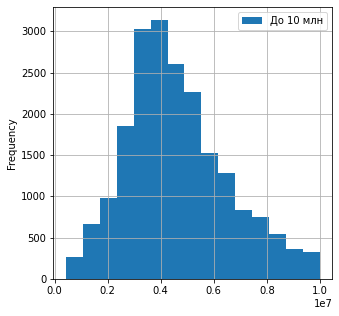

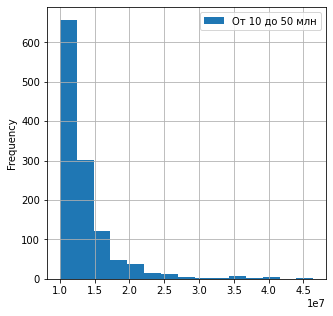

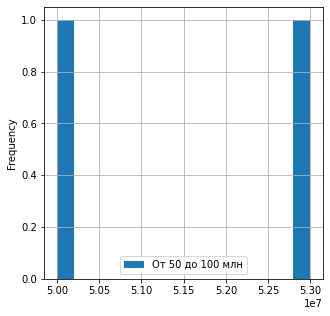

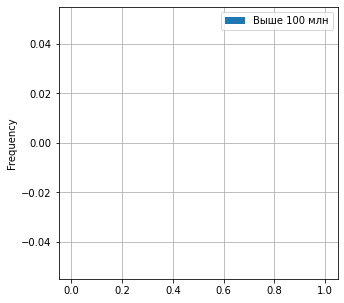

In [54]:
#Стоимость квартир

data.query('last_price<1*1e7').plot(y='last_price',kind='hist',bins=15,figsize=(5,5),label='До 10 млн',grid=True)
data.query('last_price>=1*1e7 and  last_price<0.5*1e8').plot(y='last_price',kind='hist'
                                                              ,bins=15,figsize=(5,5),label='От 10 до 50 млн',grid=True)
data.query('last_price>=0.5*1e8 and last_price<1*1e8').plot(y='last_price'
                                                              ,kind='hist',bins=15,figsize=(5,5),grid=True
                                                            ,label='От 50 до 100 млн')
data.query('last_price>=1*1e8').plot(y='last_price'
                                     ,kind='hist',bins=15,figsize=(5,5),grid=True
                                     ,label='Выше 100 млн')


Больше всего квартир стоимостью 3-4 млн руб. В выборке до 10 млн стоимость квартир меняется по нормальному распределению, далее с ростом цен по Пуансону. Но квартиры от 50 до 100 млн изменяются по близко к линейному закону- это интересно.

<AxesSubplot:ylabel='Frequency'>

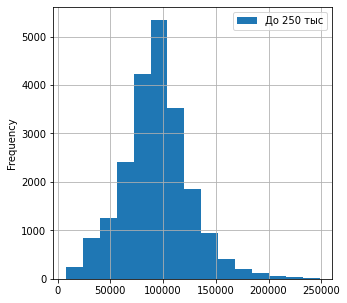

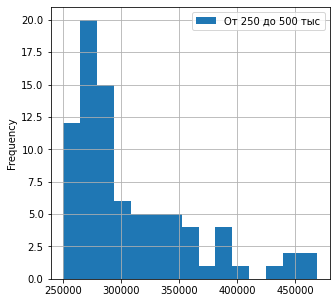

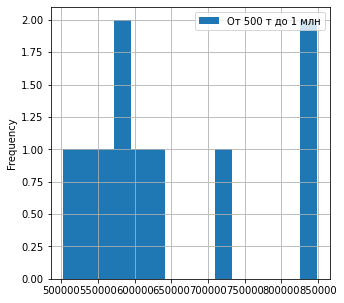

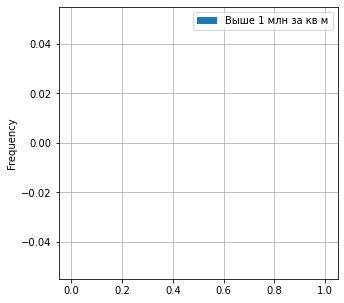

In [55]:
#Стоимость квадратного метра
data.query('price_for_m2<0.25*1e6').plot(y='price_for_m2',kind='hist',bins=15,figsize=(5,5),label='До 250 тыс',grid=True)
data.query('price_for_m2>=0.25*1e6 and  price_for_m2<0.5*1e6').plot(y='price_for_m2',kind='hist'
                                                              ,bins=15,figsize=(5,5),label='От 250 до 500 тыс',grid=True)
data.query('price_for_m2>=0.5*1e6 and price_for_m2<1*1e6').plot(y='price_for_m2'
                                                              ,kind='hist',bins=15,figsize=(5,5),grid=True
                                                            ,label='От 500 т до 1 млн')
data.query('price_for_m2>=1*1e6').plot(y='price_for_m2'
                                     ,kind='hist',bins=15,figsize=(5,5),grid=True
                                     ,label='Выше 1 млн за кв м')


Самая частая стоимость квадратного метра помещения 75-100т руб. До 250 имеет место нормальное распределение. После чего стоимость кв метра распределяется по Пуансону. 


Возможно я не совсем прав, разбивая и описывая распределение сегментов выборки. Общая выборка цен за кв-у и за метр квадратный меняется по Пуансону.

In [56]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21626 entries, 0 to 21625
Data columns (total 30 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          21626 non-null  int64         
 1   last_price            21626 non-null  float64       
 2   total_area            21626 non-null  float64       
 3   first_day_exposition  21626 non-null  datetime64[ns]
 4   rooms                 21626 non-null  int64         
 5   ceiling_height        21626 non-null  float64       
 6   floors_total          21626 non-null  int64         
 7   living_area           19922 non-null  float64       
 8   floor                 21626 non-null  int64         
 9   is_apartment          21626 non-null  bool          
 10  studio                21626 non-null  bool          
 11  open_plan             21626 non-null  bool          
 12  kitchen_area          19716 non-null  float64       
 13  balcony         

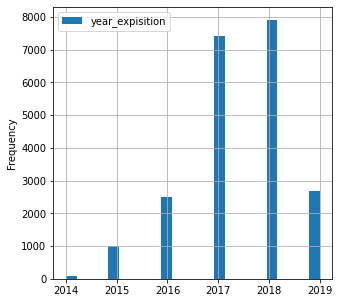

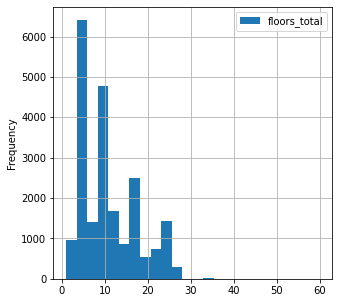

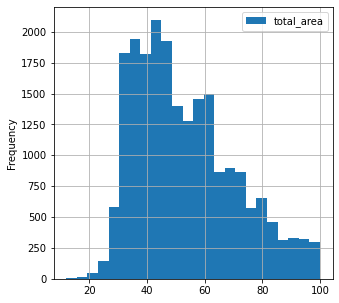

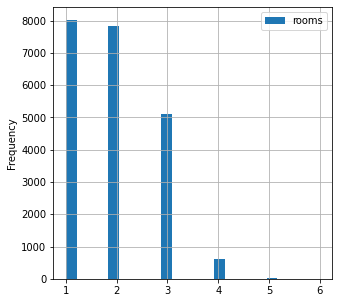

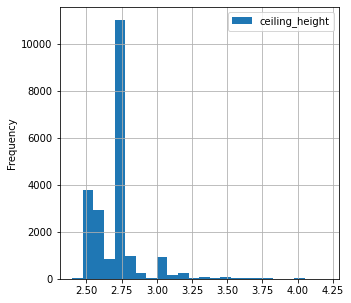

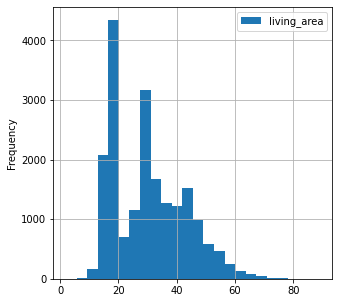

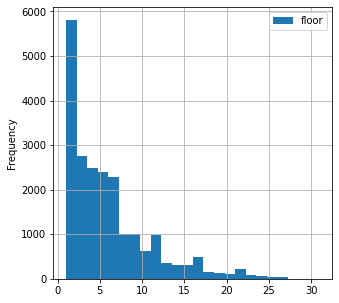

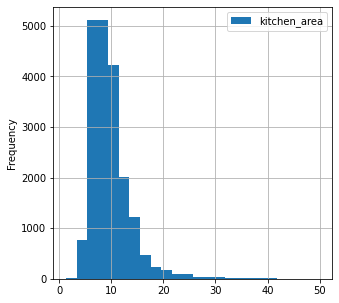

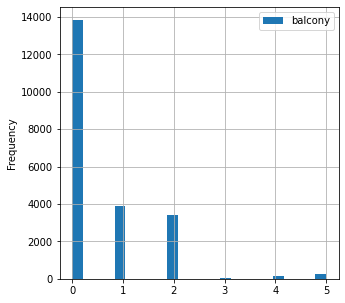

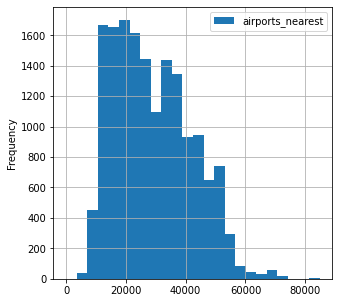

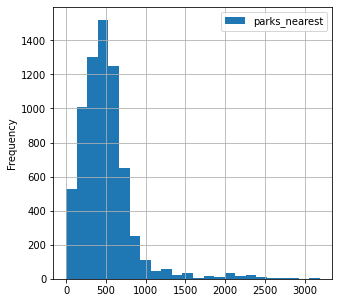

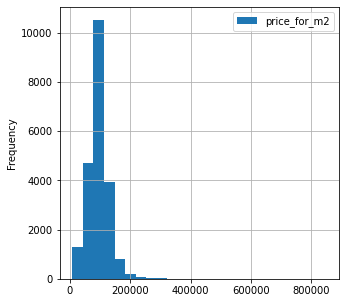

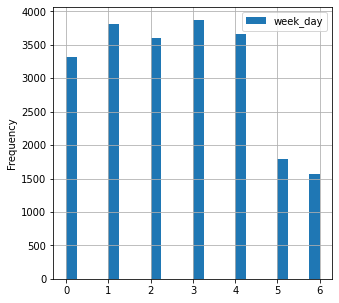

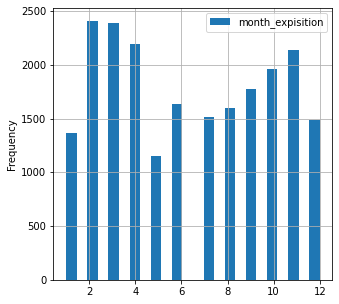

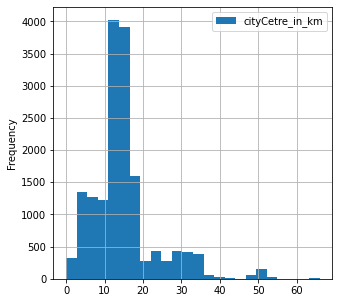

In [57]:

col_for_hist=['year_expisition',"floors_total", 'total_area','rooms', 'ceiling_height', 'living_area', 'floor'
              ,'kitchen_area', 'balcony','airports_nearest','parks_nearest','price_for_m2', 'week_day','month_expisition', 'cityCetre_in_km']
for i in col_for_hist:
    data.plot(y=i,kind='hist',bins=24,figsize=(5,5),grid=True)
    #if i=='parks_nearest':
      #  data.query("parks_nearest>0").plot(y=i,kind='hist',bins=24,figsize=(5,5),grid=True)
    #else:
    #    data.plot(y=i,kind='hist',bins=24,figsize=(5,5),grid=True)
    

In [58]:
floor_dict={'Первый':0,'Другой':2,'Последний':1}
#data['floor_type'].sum()#=data['floor_type'].astype('string')
#data.plot(y="floor_type".count(),kind='hist',bins=24,figsize=(5,5),grid=True)
for i in range(len(data['floor_type'])):
    data.loc[i,'floor_type_num']=floor_dict[data.loc[i,'floor_type']]
data['floor_type_num']=data['floor_type_num'].astype('int')
#data['floor_type_num']

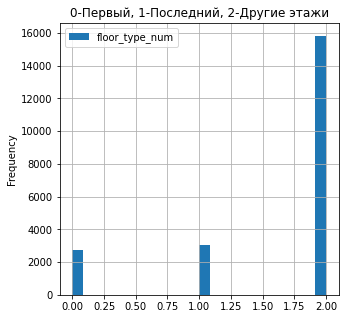

In [59]:
data.plot(y="floor_type_num",kind='hist',bins=24,figsize=(5,5),grid=True)
plt.title('0-Первый, 1-Последний, 2-Другие этажи');

<AxesSubplot:>

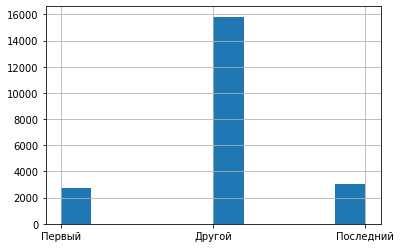

In [60]:
#код ревьюера
data['floor_type'].hist()

Вывод по гистограммам выше:

Сервис Яндекс.Недвижимость набирал попоулярность в 2014-2016, и пик популярности был в 2017-2018.

Количество этаж имеет всплески в классических планах зданий (5, 9, 16 эт и тд)

Больше всего недвижимости с общей площадью 52 кв метра.

Подавляющее большенство квартир это 'однушки' и "двушки". Близкое количество трехкомнатных квартир, а дальше идет сильный спад с каждой комнатой.

Потолки наиболее часто встречающиеся - 2.75 метра. затем идут 2.5-2.6, еще реже встречаются потолки 3-3.25. А дальше очень редкие случаи

С количеством этажей интересная картинка, но если я не ошибаюсь-она логичная. Чем выше этаж, тем таких квартир меньше. Но есть инетерсные всплески, и видимо они в районе 5,9,12 ,18 этаже - типичное этажирование зданий, и наверное это квартиры на полседний этажах данных зданий. Можно сделать вывод- квартиры на последних этажах больше продаются (не считая первых).

Кухня в 9 кв м - самая распространенная.

В выходные меньше всего выставляют на продажу недвижимость.

Чаще всего ближайший парк находится в 500 метрах.

Обычно ближайший аэропорт в 26 км.

Недвижимость без балконов самая распространенная. 1 и 2 балкона встречаются примерно одинаково. Случаи с3,4 и 5 балконами редкие и подозрительные. Я честно не уверен что бывают 5 балконов, но мб это специфика лофтов, пока оставлю как есть да и спросить не у кого.

Декабрь-Январь затишье по продажам квартир, как и Май-Август, Осенью имеется тендеция к росту продаваемых квартир. В Феврале основной скачек, который сбавляется к Маю.

Чаще всего квартиры находятся в 11-16 км от центра.

Типы этажей - больше всего в продаже не первых и последних, что логично. В домах чаще всего один первый один последний этаж)) По этой причине количество первых и последних этажей почти равно.



Анализ столбца с дням до снятия объявления.

<AxesSubplot:ylabel='Frequency'>

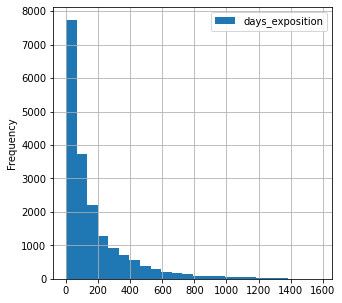

In [61]:
data.query('days_exposition>0').plot(y='days_exposition',kind='hist',bins=24,figsize=(5,5),grid=True)

In [62]:
data['days_exposition'].describe()

count    18911.000000
mean       173.364021
std        211.746030
min          1.000000
25%         44.000000
50%         92.000000
75%        219.000000
max       1580.000000
Name: days_exposition, dtype: float64

Среднее= 173 дней, Медиана 92 дней.

Обычно продажа занимает 3 месяца. 

Думаю очень быстрыми продажами можно считать те, которые располагаются в первом квартиле - до 44 дней.

Долгие продажи начинаются от 3 месяцев, а очень долгие начинаются от 219 дней.

In [63]:
data.columns

Index(['total_images', 'last_price', 'total_area', 'first_day_exposition',
       'rooms', 'ceiling_height', 'floors_total', 'living_area', 'floor',
       'is_apartment', 'studio', 'open_plan', 'kitchen_area', 'balcony',
       'locality_name', 'airports_nearest', 'cityCenters_nearest',
       'parks_around3000', 'parks_nearest', 'ponds_around3000',
       'ponds_nearest', 'days_exposition', 'price_for_m2', 'week_day',
       'week_day_1', 'month_expisition', 'month_expisition_1',
       'year_expisition', 'floor_type', 'cityCetre_in_km', 'floor_type_num'],
      dtype='object')

Какие факторы больше всего влияют на общую стоимость объекта

In [64]:
#data_not_zeros=data.query('kitchen_area>0 and living_area>0 and days_exposition>0')
#data_without_strange=data_not_zeros.query('total_area<100 and rooms<10 and living_area<100 and kitchen_area<100')

Здесь я наконец убрал выбросы из выборки, в общем они не сильно повлияли на корреляцию, но матрица стала выглядеть нагляднее.


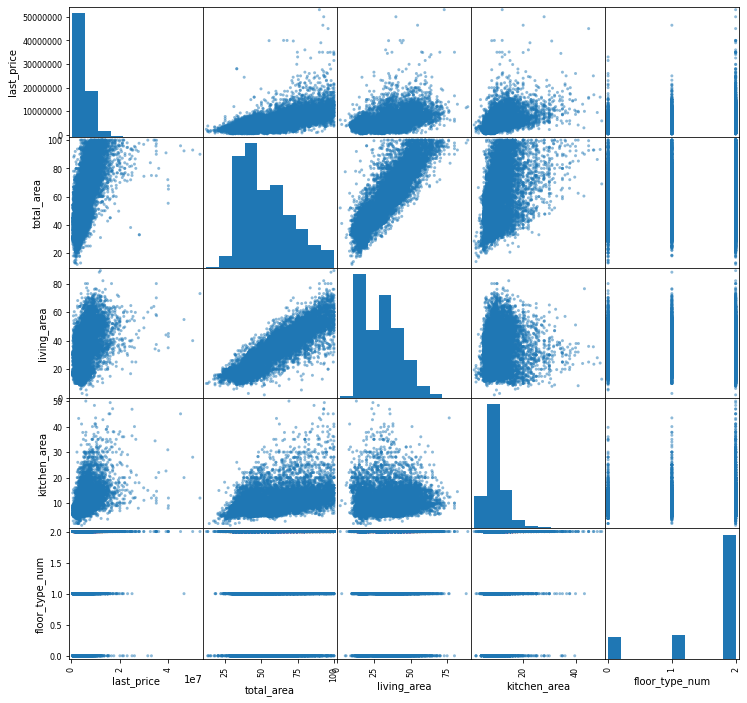

In [66]:
pd.plotting.scatter_matrix(data[['last_price','total_area','living_area','kitchen_area'
                          ,'floor_type_num']], figsize=(12, 12));

#pd.plotting.scatter_matrix(data_without_strange[['last_price','week_day', 'month_expisition''rooms',]], figsize=(12, 12)) 

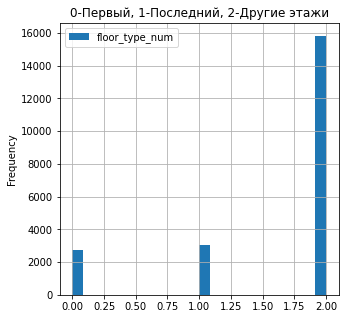

In [67]:
data.plot(y="floor_type_num",kind='hist',bins=24,figsize=(5,5),grid=True)
plt.title('0-Первый, 1-Последний, 2-Другие этажи');

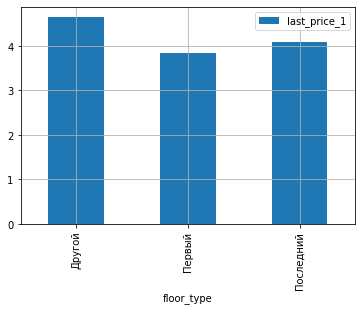

In [68]:
data['last_price_1']=data['last_price']/1000000
data.pivot_table(index='floor_type', values='last_price_1',aggfunc='median').plot.bar(grid=True);

Получается медианная цена за квартиры самая низкая для жилья на первых этажах, средняя на последних, и самая высокая средняя цена у других этажей.

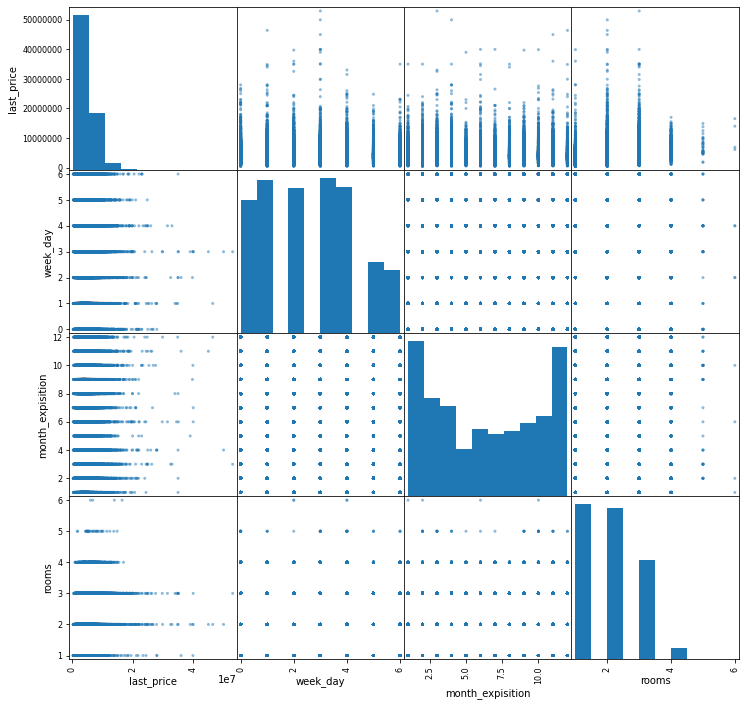

In [69]:
pd.plotting.scatter_matrix(data[['last_price','week_day', 'month_expisition','rooms',]], figsize=(12, 12));

In [70]:
data.corr()['last_price'].sort_values() # Коэффициенты корреляции

cityCetre_in_km       -0.337573
cityCenters_nearest   -0.336431
ponds_nearest         -0.085956
airports_nearest      -0.038255
studio                -0.017513
week_day              -0.015568
month_expisition      -0.000670
open_plan              0.002088
year_expisition        0.005933
parks_nearest          0.045492
is_apartment           0.057092
balcony                0.064486
days_exposition        0.079648
floor                  0.104131
floor_type_num         0.136232
floors_total           0.141978
total_images           0.157582
parks_around3000       0.159460
ponds_around3000       0.196156
rooms                  0.355438
ceiling_height         0.365521
kitchen_area           0.502349
living_area            0.513634
total_area             0.652193
price_for_m2           0.766881
last_price             1.000000
last_price_1           1.000000
Name: last_price, dtype: float64

Итак по матрицам корреляции видно, что день недели, месяц не коррелируют со стоимостью. 
А вот и рейтинг самых влияющих на цену квартиры параметров:

1-общая площадь;
2-жилая площадь;
3-площадь кухни.

Слабую корреляцию проявляют: Число комнат, высота потолка.

Растояние до центра города имеет слабую обратую корреляцию.

Остальные параметры не имеют корреляции со стоимостью квартиры.

Медианная цена за квартиры самая низкая для жилья на первых этажах, средняя на последних, и самая высокая средняя цена у других этажей.

Топ 10 населённых пунктов по количеству объявлений

In [71]:
mean_price_for_m2=data.pivot_table(index='locality_name',values='price_for_m2',aggfunc=['mean','count'])

mean_price_for_m2.columns=['mean_price_for_m2','count']
mean_price_for_m2=mean_price_for_m2.sort_values(by='count',ascending=False).head(10)
mean_price_for_m2

,mean_price_for_m2,count
locality_name,,
Санкт-Петербург,109869.755111,13919
ПГТ Мурино,85004.057852,529
ПГТ Шушары,78511.871633,427
Всеволожск,68672.909865,386
Пушкин,101259.667912,339
Колпино,75322.233737,332
ПГТ Парголово,90613.495807,320
Гатчина,68938.457193,301
деревня Кудрово,92210.740409,281


Топ 1 и Топ 10 по средней стоимости квадратного метра 

In [72]:
display(mean_price_for_m2[mean_price_for_m2['mean_price_for_m2']==mean_price_for_m2['mean_price_for_m2'].max()]
      ,mean_price_for_m2[mean_price_for_m2['mean_price_for_m2']==mean_price_for_m2['mean_price_for_m2'].min()])

,mean_price_for_m2,count
locality_name,,
Санкт-Петербург,109869.755111,13919


,mean_price_for_m2,count
locality_name,,
Выборг,58236.423983,220


Самая высокая стоимост квадратного метра в Санкт-Петербурге =109869 рублей за кв метр, а самая низка в Выборге=58236 рублей за квадратный метр.

Найду стоимость километра

In [73]:
data.describe()

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,...,ponds_around3000,ponds_nearest,days_exposition,price_for_m2,week_day,month_expisition,year_expisition,cityCetre_in_km,floor_type_num,last_price_1
count,21626.000000,2.162600e+04,21626.000000,21626.000000,21626.000000,21626.000000,19922.000000,21626.000000,19716.000000,21626.000000,...,16283.000000,7915.000000,18911.000000,21626.000000,21626.000000,21626.000000,21626.000000,16282.000000,21626.000000,21626.000000
mean,9.761537,5.109246e+06,53.158861,1.927633,2.693905,10.745399,30.320291,5.893554,9.713376,0.591002,...,0.728183,526.753885,173.364021,95156.911894,2.571673,6.384676,2017.390271,14.800025,1.605105,5.109246
std,5.579862,2.986509e+06,17.438239,0.855739,0.177298,6.593737,12.469993,4.884861,4.035445,0.943819,...,0.908710,277.090288,211.746030,36793.753488,1.794705,3.489617,1.025729,8.517731,0.701430,2.986509
min,0.000000,4.300000e+05,12.000000,1.000000,2.400000,1.000000,2.000000,1.000000,1.300000,0.000000,...,0.000000,13.000000,1.000000,7962.962963,0.000000,1.000000,2014.000000,0.000000,0.000000,0.430000
25%,6.000000,3.350000e+06,39.300000,1.000000,2.600000,5.000000,18.200000,2.000000,7.000000,0.000000,...,0.000000,308.000000,44.000000,75335.616438,1.000000,3.000000,2017.000000,10.000000,1.000000,3.350000
50%,9.000000,4.490000e+06,50.000000,2.000000,2.700000,9.000000,29.500000,4.000000,9.000000,0.000000,...,0.000000,511.000000,92.000000,93625.000000,3.000000,6.000000,2017.000000,13.000000,2.000000,4.490000
75%,14.000000,6.100000e+06,64.000000,3.000000,2.700000,16.000000,39.300000,8.000000,11.000000,1.000000,...,1.000000,734.000000,219.000000,111666.666667,4.000000,10.000000,2018.000000,17.000000,2.000000,6.100000
max,50.000000,5.300000e+07,100.000000,6.000000,4.200000,60.000000,89.100006,31.000000,50.000000,5.000000,...,3.000000,1344.000000,1580.000000,848484.848485,6.000000,12.000000,2019.000000,66.000000,2.000000,53.000000


In [74]:
data_stPiter=data.query('locality_name=="Санкт-Петербург" and cityCetre_in_km>0')
data_stPiter=data_stPiter.reset_index(drop=True)
data_stPiter

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,price_for_m2,week_day,week_day_1,month_expisition,month_expisition_1,year_expisition,floor_type,cityCetre_in_km,floor_type_num,last_price_1
0,10,5196000.0,56.00,2015-08-20,2,2.70,5,34.3,4,False,...,92785.714286,3,Четверг,8,Август,2015,Другой,14.0,2,5.196
1,2,10000000.0,100.00,2018-06-19,2,3.03,14,32.0,13,False,...,100000.000000,1,Вторник,6,Июнь,2018,Другой,8.0,2,10.000
2,5,7915000.0,71.60,2019-04-18,2,2.70,24,NaN,22,False,...,110544.692737,3,Четверг,4,Апрель,2019,Другой,12.0,2,7.915
3,18,5400000.0,61.00,2017-02-26,3,2.50,9,43.6,7,False,...,88524.590164,6,Воскресенье,2,Февраль,2017,Другой,15.0,2,5.400
4,5,5050000.0,39.60,2017-11-16,1,2.67,12,20.3,3,False,...,127525.252525,3,Четверг,11,Ноябрь,2017,Другой,14.0,2,5.050
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13856,6,3200000.0,39.00,2017-12-16,1,2.70,9,20.0,6,False,...,82051.282051,5,Суббота,12,Декабрь,2017,Другой,17.0,2,3.200
13857,13,3550000.0,35.30,2018-02-28,1,2.86,15,16.3,4,False,...,100566.572238,2,Среда,2,Февраль,2018,Другой,16.0,2,3.550
13858,3,5500000.0,52.00,2018-07-19,2,2.70,5,31.0,2,False,...,105769.230769,3,Четверг,7,Июль,2018,Другой,6.0,2,5.500
13859,11,9470000.0,72.90,2016-10-13,2,2.75,25,40.3,7,False,...,129903.978052,3,Четверг,10,Октябрь,2016,Другой,4.0,2,9.470


In [75]:
for i in range(len(data_stPiter)):
    data_stPiter.loc[i,'price_for_km']=data_stPiter.loc[i,"last_price"]/data_stPiter.loc[i,"cityCetre_in_km"]
    


In [76]:
data_stPiter.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,week_day,week_day_1,month_expisition,month_expisition_1,year_expisition,floor_type,cityCetre_in_km,floor_type_num,last_price_1,price_for_km
0,10,5196000.0,56.0,2015-08-20,2,2.70,5,34.3,4,False,...,3,Четверг,8,Август,2015,Другой,14.0,2,5.196,3.711429e+05
1,2,10000000.0,100.0,2018-06-19,2,3.03,14,32.0,13,False,...,1,Вторник,6,Июнь,2018,Другой,8.0,2,10.000,1.250000e+06
2,5,7915000.0,71.6,2019-04-18,2,2.70,24,NaN,22,False,...,3,Четверг,4,Апрель,2019,Другой,12.0,2,7.915,6.595833e+05
3,18,5400000.0,61.0,2017-02-26,3,2.50,9,43.6,7,False,...,6,Воскресенье,2,Февраль,2017,Другой,15.0,2,5.400,3.600000e+05
4,5,5050000.0,39.6,2017-11-16,1,2.67,12,20.3,3,False,...,3,Четверг,11,Ноябрь,2017,Другой,14.0,2,5.050,3.607143e+05


Определим как связаны между собой стоимость жилья от удаленности от центра города.

In [77]:
data_stPiter.corr()['price_for_km']

total_images           0.037655
last_price             0.610849
total_area             0.352873
rooms                  0.205010
ceiling_height         0.401293
floors_total          -0.201027
living_area            0.320208
floor                 -0.124481
is_apartment           0.000155
studio                -0.005002
open_plan              0.005799
kitchen_area           0.254881
balcony               -0.073202
airports_nearest      -0.095152
cityCenters_nearest   -0.554858
parks_around3000       0.250005
parks_nearest         -0.032823
ponds_around3000       0.301899
ponds_nearest         -0.195246
days_exposition        0.098303
price_for_m2           0.528674
week_day              -0.007568
month_expisition      -0.007073
year_expisition       -0.032206
cityCetre_in_km       -0.557381
floor_type_num        -0.021934
last_price_1           0.610849
price_for_km           1.000000
Name: price_for_km, dtype: float64

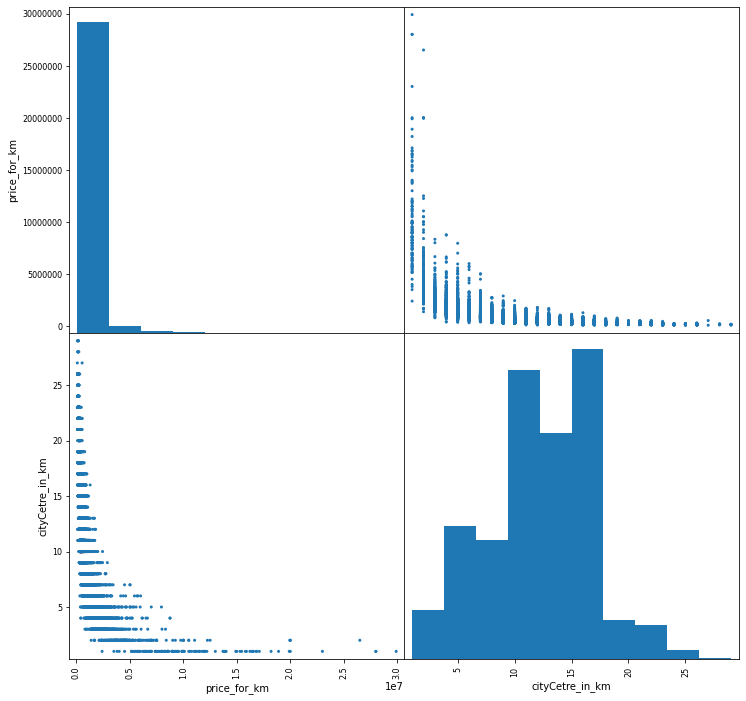

In [78]:
pd.plotting.scatter_matrix(data_stPiter[['price_for_km','cityCetre_in_km']]
                           , figsize=(12, 12), grid=True,alpha=1);

По матрице рассеивания видно, что чем дальше центр города, тем дешевле квартира(коэффициент корреляции -0.55). Однако это уже не сильно решает после 3 км. Более сильная корреляция для растояния до 3 км, и менее выраженная после.

### Общий вывод

Был проведен исследовательский анализ данных сервиса Яндекс Недвижимость — архива объявлений за несколько лет о продаже квартир в Санкт-Петербурге и соседних населённых пунктах.

Была проведена предобработка данных, в которой были заполнены пропуски значений, унифицированны названия населенных пунктов с последующим устранение неявных дубликатов, изменены типы данных.

С датафреймом с данными были выполнены следующие операции: 
 >посчитано и добавлено в таблицу: цена одного квадратного метра
 посчитано и добавлено в таблицу: день публикации объявления (0 - понедельник, 1 - вторник и т.д.)
 посчитано и добавлено в таблицу: месяц публикации объявления
 посчитано и добавлено в таблицу: год публикации объявления
 посчитано и добавлено в таблицу: тип этажа квартиры (значения — «первый», «последний», «другой»)
 посчитано и добавлено в таблицу: расстояние в км до центра города
 
Далее были проанализированы основные столбцы датафрейма и сделаны следующие выводы:

>Сервис Яндекс.Недвижимость набирал попоулярность в 2014-2016, и пик популярности был в 2017-2018.

>Количество этаж имеет всплески в классических планах зданий (5, 9, 16 эт и тд)

>Больше всего недвижимости с общей площадью 52 кв метра.

>Подавляющее большенство квартир это 'однушки' и "двушки". Близкое количество трехкомнатных квартир, а дальше идет сильный спад с каждой комнатой.

>Потолки наиболее часто встречающиеся - 2.75 метра. затем идут 2.5-2.6, еще реже встречаются потолки 3-3.25. А дальше очень редкие случаи

>С количеством этажей интересная картинка, но если я не ошибаюсь-она логичная. Чем выше этаж, тем таких квартир меньше. Но есть инетерсные всплески, и видимо они в районе 5,9,12 ,18 этаже - типичное этажирование зданий, и наверное это квартиры на полседний этажах данных зданий. Можно сделать вывод- квартиры на последних этажах больше продаются (не считая первых).

>Кухня в 9 кв м - самая распространенная.

>В выходные меньше всего выставляют на продажу недвижимость.

>Чаще всего ближайший парк находится в 500 метрах.

>Обычно ближайший аэропорт в 26 км.

>Недвижимость без балконов самая распространенная. 1 и 2 балкона встречаются примерно одинаково. Случаи с3,4 и 5 балконами редкие и подозрительные. Я честно не уверен что бывают 5 балконов, но мб это специфика лофтов, пока оставлю как есть да и спросить не у кого.

>Декабрь-Январь затишье по продажам квартир, как и Май-Август, Осенью имеется тендеция к росту продаваемых квартир. В Феврале основной скачек, который сбавляется к Маю.

>Чаще всего квартиры находятся в 11-16 км от центра.

>Типы этажей - больше всего в продаже не первых и последних, что логично. В домах чаще всего один первый один последний этаж)) По этой причине количество первых и последних этажей почти равно.

>Медианная цена за квартиры самая низкая для жилья на первых этажах, средняя на последних, и самая высокая средняя цена у других этажей.

Был изучен вопрос, касаемый скорости продаж квартир. Заключение по вопросу:
>Среднее= 173 дней, Медиана 92 дней.

>Обычно продажа занимает 3 месяца. 

>Думаю очень быстрыми продажами можно считать те, которые располагаются в первом квартиле - до 44 дней.

>Долгие продажи начинаются от 3 месяцев, а очень долгие начинаются от 219 дней.

Было изучено какие факторы влияют на общую стоимость квартиры:
>1-общая площадь;
2-жилая площадь;
3-площадь кухни.

>Слабую корреляцию проявляют: Число комнат, высота потолка.

>Растояние до центра города имеет слабую обратую корреляцию.

>Остальные параметры не имеют корреляции со стоимостью квартиры.

Были определены самые высоки и низкие цены за квадратный метр квартир, в самых распротраненных населенных пунктах:
>Самая высокая стоимост квадратного метра в Санкт-Петербурге =109869 рублей за кв метр, а самая низка в Выборге=58236 рублей за квадратный метр.

Была определена зависимость цены квартиры от удаленности от центра города:
>Чем дальше центр города, тем дешевле квартира(коэффициент корреляции равен -0.55). Однако это уже не сильно решает после 3 км. Более сильная корреляция для растояния до 3 км, и менее выраженная после.